In [1]:
from datetime import date
from glob import glob
import io
import json
import math
import os
from pathlib import Path
import pickle
from PIL import Image
import sys
import time

import gspread
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats
from pptx import Presentation
from pptx.util import Inches

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
# from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [6]:
data_dir = Path(r"F:\\")

In [24]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\brain_states_analyses\NPX analysis'

In [8]:
inj_states = ['psilocybin', 'ketanserin', 'saline']

### Load subjects .csv

In [9]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\psilocybin_saline_subjects_2024_07.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze_EEG': bool, 'analyze_NPX': bool})

In [10]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,saline,654182,estim_vis_2022-12-01_10-33-50,"awake,saline","3,6,14,22,23",True,True,25,NaN
4,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN


### Multisubject analysis

In [11]:
StimType = 'biphasic'

inj_window = np.array([30, 60]) * 60 # min to include as "psilocybin" -> seconds

trial_threshold = 20 # must have more than this number of trials to be included in analysis
trial_max = 100 # limit some states that have many trials

behaviors = {'rest': True, 'run': False}

ROI = 'SM-TH'
time_bin = 0.005 # size of time bins (s) for firing rate
unit_threshold = 5 # must have at least this number of units to be included in analysis, 5/10 was 5
burst_window = [0.075, 0.25] # SR late window [0.15, 0.25]

In [13]:
all_sub_metrics = []
for dfind, subrow in subject_df.iterrows():
    print('{}: {}'.format(subrow.mouse, subrow.exp_type))
    if not subrow.analyze_NPX:
        print(' Not analyzing this experiment: "analyze"=False.\n')
        continue
    
    data_paths = os.path.join(data_dir, '*', 'mouse'+subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
    if len(glob(data_paths)) == 0:
        print(' This data path does not exist: {}\n'.format(data_paths))
        continue
    else:
        data_loc = glob(data_paths)[0]
    subexp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)

    ## Grab exp metadata from Templeton-log_exp ##
    if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
        exp_meta = Temp_metadata[(
            (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
        exp_meta = ZZ_metadata[(
            (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    else:
        print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

    ## Get injection times ##
    if subrow.exp_type in inj_states:
        inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    else:
        print('  This {} experiment has no injection times.'.format(subrow.exp_type))
        inj_times = None

    ## Load stim log and apply sweep labels ##
    stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
    ### Get state label for each sweep ###
    all_sweeps = np.unique(stim_log['sweep'].values)
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    ### Get list of states and the middle current ###
    states = np.unique(stim_log['state'].values)
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
    else:
        estim_current = {'mid': str(currents[0])}

    
    ## Load unit info ##
    fn_units_info = os.path.join(subexp.data_folder, 'evoked_data', 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(subexp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
            all_unit_event_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_info))
        continue
    
    ## Make time bins for event spikes ##
    bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
    timex = bins[:-1] + time_bin/2
    
    ## Select unit info for ROI ##
    ROIdf = unit_info[unit_info['parent_region'] == ROI].reset_index(drop=True)
    if len(ROIdf) < unit_threshold:
        print(' {} has {:d} units, skipping.\n'.format(ROI, len(ROIdf)))
        continue

    ## Get metrics for all trial types ##
    estimlog = stim_log[stim_log['stim_type'] == StimType]
    for clevel, parami in estim_current.items():
        for behi, restTF in behaviors.items():
            for statei in states:
                eventdf = get_events_wdict(
                    estimlog, {'state': statei, 'parameter': parami, 'good': True, 'resting_trial': restTF}, out='df')
                ## Add injection times ##
                if statei in inj_states:
                    eventdf['onset_from_inj'] = eventdf['onset'] - inj_times[1]
                    event_inds = eventdf[(eventdf['onset_from_inj'] > inj_window[0]) & (eventdf['onset_from_inj'] < inj_window[1])].index.values
                else:
                    event_inds = eventdf.index.values
                if len(event_inds) < trial_threshold:
                    continue
                elif len(event_inds) > trial_max:
                    event_inds = np.random.choice(event_inds, size=trial_max, replace=False)

                ## Get burst metrics for ROI ##
                burst_trials = np.zeros(len(ROIdf), dtype=float)
                # mean_burst_counts = np.zeros(len(ROIdf), dtype=float)
                for ii, unitrow in ROIdf.iterrows():
                    unit_event_bursts = [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds]
                    trial_counts = np.zeros(len(event_inds), dtype=int)
                    # burst_counts = np.zeros(len(event_inds), dtype=int)
                    for jj, uburstsi in enumerate(unit_event_bursts):
                        ## Count bursts ##
                        windowbursts = np.nonzero((uburstsi >= burst_window[0]) & (uburstsi <= burst_window[1]))[0]
                        if len(windowbursts) > 0:
                            trial_counts[jj] = 1
                        # burst_counts[jj] = len(np.nonzero(uburstsi >= burst_window[0])[0])
                    burst_trials[ii] = np.mean(trial_counts) # fraction of trials with burst
                    # mean_burst_counts[ii] = np.mean(burst_counts) # avg number of evoked bursts

                all_sub_metrics.append([subrow.mouse, subrow.exp_type, statei, clevel, behi, len(event_inds), np.mean(burst_trials)])

    print('')
EEG_metrics = pd.DataFrame(all_sub_metrics, columns=['mouse', 'experiment', 'state', 'stim_current', 'behavior', 'num_trials', 'avg_burst_prob'])

582386: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

638703: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.
 SM-TH has 0 units, skipping.

654181: urethane
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

654182: saline
Experiment type: electrical and sensory stimulation

654182: urethane
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

631037: saline
Experiment type: electrical stimulation

631037: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

655955: saline
Experiment type: electrical stimulation

655955: urethane
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

655956: saline
Experiment type: electrical stimulation

655956: urethane
Experiment type: electrical stimulation

In [14]:
EEG_metrics.head()

,mouse,experiment,state,stim_current,behavior,num_trials,avg_burst_prob
0,582386,urethane,urethane,mid,rest,100,0.041818
1,654181,urethane,urethane,low,rest,100,0.022612
2,654181,urethane,urethane,mid,rest,100,0.028209
3,654181,urethane,urethane,high,rest,100,0.029701
4,654182,saline,awake,low,rest,94,0.146069


#### Get pre vs post values

In [15]:
prepost = []
metric = 'avg_burst_prob' # 'PCIst', 'response_duration'
for expi in np.unique(EEG_metrics['experiment'].values):
    expdf = EEG_metrics[EEG_metrics['experiment'] == expi]
    for mousei in np.unique(expdf['mouse'].values):
        if expi == 'urethane':
            subdf = EEG_metrics[EEG_metrics['mouse'] == mousei]
            if len(np.unique(subdf['experiment'].values)) < 2:
                continue
            else:
                for slev in ['low', 'mid', 'high']:
                    urdf = expdf[(expdf['mouse'] == mousei) & (expdf['stim_current'] == slev) & (expdf['behavior'] == 'rest')]
                    awdf = subdf[(subdf['state'] == 'awake') & (subdf['stim_current'] == slev) & (subdf['behavior'] == 'rest')]
                    if (len(urdf) == 1) & (len(awdf) > 0):
                        prepost.append([mousei, expi, slev, 'rest', np.max(awdf[metric].values), urdf[metric].values[0]])
        else:
            for slev in ['low', 'mid', 'high']:
                for behi in behaviors.keys():
                    tdf = expdf[(expdf['mouse'] == mousei) & (expdf['stim_current'] == slev) & (expdf['behavior'] == behi)]
                    if len(tdf) == 2:
                        prepost.append([
                            mousei, expi, slev, behi, tdf[tdf['state'] == 'awake'][metric].values[0], tdf[tdf['state'] == expi][metric].values[0]
                        ])
prepostdf = pd.DataFrame(prepost, columns=['mouse', 'experiment', 'stim_current', 'behavior', 'pre', 'post'])
prepostdf.head()

,mouse,experiment,stim_current,behavior,pre,post
0,676726,isoflurane,mid,rest,0.013371,0.009664
1,676727,isoflurane,mid,rest,0.042702,0.009643
2,688277,isoflurane,low,rest,0.017647,0.009265
3,688277,isoflurane,mid,rest,0.023109,0.008235
4,688277,isoflurane,high,rest,0.030532,0.005294


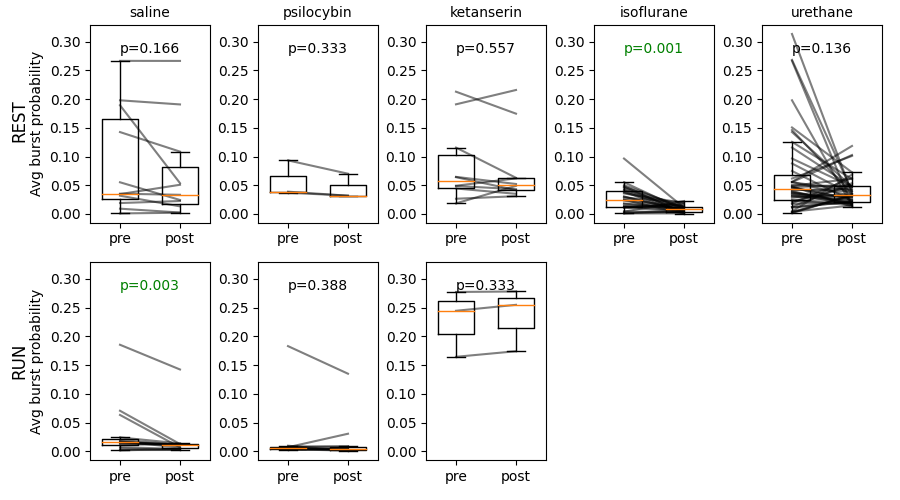

In [23]:
plot_exps = ['saline', 'psilocybin', 'ketanserin', 'isoflurane', 'urethane']

fig = plt.figure(figsize=(9,5))
gs = fig.add_gridspec(ncols=len(plot_exps), nrows=len(behaviors), left=0.1, right=0.98, top=0.95, bottom=0.08, hspace=0.2, wspace=0.4)

axlist = []
plist = []
for coli, expi in enumerate(plot_exps):
    for rowi, behi in enumerate(behaviors.keys()):
        plotdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['behavior'] == behi)]
        if len(plotdf) > 0:
            wstats = pg.wilcoxon(x=plotdf['pre'].values, y=plotdf['post'].values, alternative='two-sided')
            # print('{}-{}: p={:.3f}'.format(expi, behi, wstats['p-val'].values[0]))
            plist.append(wstats['p-val'].values[0])
            ax = fig.add_subplot(gs[rowi, coli])
            ax.plot([0,1], [plotdf['pre'].values, plotdf['post'].values], color='k', linewidth=1.5, alpha=0.5)
            ax.boxplot([plotdf['pre'].values, plotdf['post'].values], positions=[0, 1], widths=[0.6, 0.6], showfliers=False)
            axlist.append(ax)
            if coli == 0:
                # ax.set_ylabel(metric)
                ax.set_ylabel('Avg burst probability')
            if rowi == 0:
                ax.set_title(expi)

## Correct p-values with Benjamini-Hochberg false discovery rate ##
corrpvals = pg.multicomp(plist, alpha=0.05, method='fdr_bh')

for ax in axlist[1:]:
    ax.sharex(axlist[0])
    ax.sharey(axlist[0])
ax.set_xticks([0,1])
ax.set_xticklabels(['pre', 'post'])

fig.text(0.012, 0.725, 'REST', fontsize=12, rotation='vertical')
fig.text(0.012, 0.25, 'RUN', fontsize=12, rotation='vertical')

for ax, pval in zip(axlist, corrpvals[1]):
    if pval < 0.05:
        tcolor = 'g'
    else:
        tcolor = 'k'
    ax.annotate('p={:.3f}'.format(pval), xy=(0.5, 0.3), ha='center', va='top', color=tcolor)

## Save ##
figname = 'allstatesEP_BURST_prepost_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Plot pre-post change

In [25]:
prepostdf['diff'] = prepostdf['post'] - prepostdf['pre']
prepostdf['percentchange'] = prepostdf['diff'] / prepostdf['pre']
prepostdf['category'] = prepostdf['experiment'] + prepostdf['behavior']
prepostdf.head()

,mouse,experiment,stim_current,behavior,pre,post,diff,percentchange,category
0,676726,isoflurane,mid,rest,0.013371,0.009664,-0.003706,-0.277209,isofluranerest
1,676727,isoflurane,mid,rest,0.042702,0.009643,-0.033059,-0.774182,isofluranerest
2,688277,isoflurane,low,rest,0.017647,0.009265,-0.008382,-0.475000,isofluranerest
3,688277,isoflurane,mid,rest,0.023109,0.008235,-0.014874,-0.643636,isofluranerest
4,688277,isoflurane,high,rest,0.030532,0.005294,-0.025238,-0.826606,isofluranerest


Text(0.5, 1.0, 'EP metric change pre to post drug intervention')

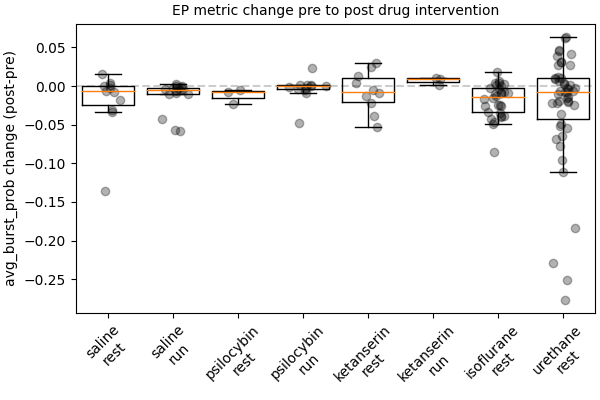

In [26]:
plot_cats = {'saline': ['rest', 'run'], 'psilocybin': ['rest', 'run'], 'ketanserin': ['rest', 'run'], 'isoflurane': ['rest'], 'urethane': ['rest']}
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

indi = 0
xts = []
xtls = []
ax.axhline(0, color='k', linestyle='dashed', alpha=0.2)
for expi, behlist in plot_cats.items():
    for behi in behlist:
        plotdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['behavior'] == behi)]
        if len(plotdf) > 0:
            xs = np.random.normal(indi, 0.1, len(plotdf)) # np.zeros(len(plotdf)) + indi
            ax.boxplot(
                plotdf['diff'].values, positions=[indi], widths=[0.8], showfliers=False,
                # medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
            )
            ax.scatter(xs, plotdf['diff'].values, c='k', marker='o', alpha=0.3)
            xts.append(indi)
            xtls.append(expi + '\n' + behi)
            indi += 1

ax.set_xticks(xts)
ax.set_xticklabels(xtls, rotation=45)
ax.set_ylabel('{} change (post-pre)'.format(metric))
ax.set_title('EP metric change pre to post drug intervention')

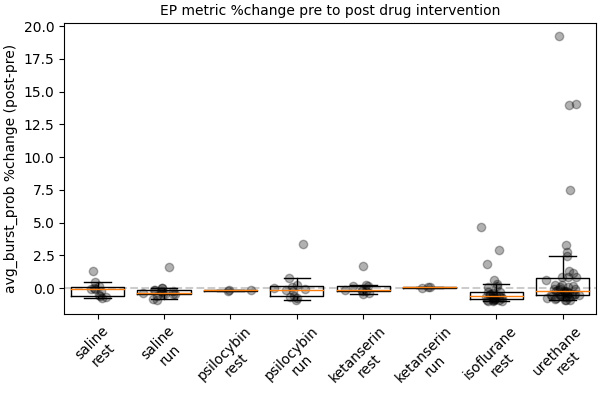

In [30]:
plot_cats = {'saline': ['rest', 'run'], 'psilocybin': ['rest', 'run'], 'ketanserin': ['rest', 'run'], 'isoflurane': ['rest'], 'urethane': ['rest']}
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

indi = 0
xts = []
xtls = []
ax.axhline(0, color='k', linestyle='dashed', alpha=0.2)
for expi, behlist in plot_cats.items():
    for behi in behlist:
        plotdf = prepostdf[(prepostdf['experiment'] == expi) & (prepostdf['behavior'] == behi)]
        if len(plotdf) > 0:
            xs = np.random.normal(indi, 0.1, len(plotdf)) # np.zeros(len(plotdf)) + indi
            ax.boxplot(
                plotdf['percentchange'].values, positions=[indi], widths=[0.8], showfliers=False,
                # medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
            )
            ax.scatter(xs, plotdf['percentchange'].values, c='k', marker='o', alpha=0.3)
            xts.append(indi)
            xtls.append(expi + '\n' + behi)
            indi += 1

ax.set_xticks(xts)
ax.set_xticklabels(xtls, rotation=45)
ax.set_ylabel('{} %change (post-pre)'.format(metric))
ax.set_title('EP metric %change pre to post drug intervention')

## Save ##
figname = 'allstatesEP_BURST_prepostpercentchange_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [28]:
allstates_kw = pg.kruskal(data=prepostdf, dv='percentchange', between='category')
allstates_kw

,Source,ddof1,H,p-unc
Kruskal,category,7,13.778392,0.055266


In [29]:
allstates_anova = pg.anova(data=prepostdf, dv='percentchange', between='category')
allstates_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,category,7,124,1.045938,0.402776,0.055753


##### What if we exclude the low current?

### Single subject exploration

In [99]:
subrow = subject_df.iloc[50]
subrow

exp_type                        isoflurane
mouse                               703063
experiment      aw_iso_2023-11-16_11-16-30
sweep_states              awake,isoflurane
bad_chs                                all
analyze_EEG                          False
analyze_NPX                           True
CCF_res                                 25
notes                  big artifact in EPs
Name: 50, dtype: object

In [100]:
data_paths = os.path.join(data_dir, '*', 'mouse'+subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
if len(glob(data_paths)) == 0:
    print(' This data path does not exist: {}\n'.format(data_paths))
    # continue
else:
    data_loc = glob(data_paths)[0]
subexp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


Grab exp metadata from Templeton-log_exp

In [101]:
if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
    exp_meta = Temp_metadata[(
        (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
    exp_meta = ZZ_metadata[(
        (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
else:
    print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

Get injection times

In [102]:
if subrow.exp_type in inj_states:
    inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
else:
    print('  This {} experiment has no injection times.'.format(subrow.exp_type))
    inj_times = None
print(inj_times)

  This isoflurane experiment has no injection times.
None


In [103]:
## Load stim log and apply sweep labels ##
stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
### Get state label for each sweep ###
all_sweeps = np.unique(stim_log['sweep'].values)
sweep_state_list = []
for char in subrow.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
### Get list of states and the middle current ###
states = np.unique(stim_log['state'].values)
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
else:
    estim_current = {'mid': str(currents[0])}

In [104]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,state
0,biphasic,25,760.48527,760.48567,0.0004,0,True,0.000000,True,awake
1,biphasic,25,767.07123,767.07163,0.0004,0,True,0.000000,True,awake
2,biphasic,35,773.83414,773.83454,0.0004,0,True,0.000000,True,awake
3,biphasic,15,781.13560,781.13600,0.0004,0,True,0.303728,False,awake
4,biphasic,15,787.66526,787.66566,0.0004,0,True,0.000000,True,awake


Load unit info

In [105]:
time_bin = 0.005 # size of time bins (s) for firing rate
unit_threshold = 5 # must have at least this number of units to be included in analysis, 5/10 was 5

In [106]:
## Load unit info ##
fn_units_info = os.path.join(subexp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(subexp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print(' {} not found. Not analyzing this subject.\n'.format(fn_units_info))
    # continue

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

## Separate unit info by ROI ##
ROI_unit_info = {}
for region in np.unique(unit_info['parent_region'].values):
    udf = unit_info[unit_info['parent_region'] == region]
    if len(udf) >= unit_threshold:
        ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
        print('{}: {:d} units'.format(region, len(udf)))

HIP: 115 units
MO: 146 units
PAL: 31 units
SM-TH: 153 units
SS: 112 units
STR: 240 units
VIS: 22 units
other-TH: 52 units


In [107]:
ROI_unit_info['SM-TH'].head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B204,probeB,81,2900,0.467002,AV,249,139,183,SM-TH
1,B206,probeB,81,2900,0.467002,AV,249,139,183,SM-TH
2,B203,probeB,80,2900,0.535678,AV,249,139,183,SM-TH
3,B202,probeB,79,2920,0.480737,AV,249,140,183,SM-TH
4,B198,probeB,77,2940,0.508208,AV,249,141,183,SM-TH


Text(0.5, 1.0, 'SM-TH')

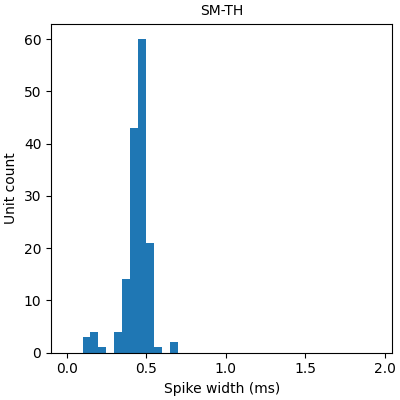

In [108]:
parea = 'SM-TH'
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.hist(ROI_unit_info[parea]['spike_duration'].values, bins=np.arange(0, 2, 0.05))
ax.set_xlabel('Spike width (ms)')
ax.set_ylabel('Unit count')
ax.set_title(parea)

### Get stats for each state/current

In [109]:
estimlog = stim_log[stim_log['stim_type'] == 'biphasic']

In [114]:
tstate = 'isoflurane'
tpar = '25'

eventdf = get_events_wdict(estimlog, {'state': tstate, 'parameter': tpar, 'good': True, 'resting_trial': True}, out='df')
event_inds = eventdf.index.values ########## should edit for inj times
print(len(eventdf))
eventdf.head()

72


,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,state
360,biphasic,25,5007.97530,5007.97570,0.0004,1,True,0.0,True,isoflurane
368,biphasic,25,5063.88344,5063.88384,0.0004,1,True,0.0,True,isoflurane
369,biphasic,25,5070.62117,5070.62157,0.0004,1,True,0.0,True,isoflurane
371,biphasic,25,5085.04399,5085.04439,0.0004,1,True,0.0,True,isoflurane
372,biphasic,25,5092.09124,5092.09164,0.0004,1,True,0.0,True,isoflurane


In [115]:
areai = 'SM-TH'
burst_window = [0.075, 0.25] # matches SR late window

regdf = ROI_unit_info[areai]
unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan
burst_trials = np.zeros(len(regdf), dtype=float)
mean_burst_counts = np.zeros(len(regdf), dtype=float)
for ii, unitrow in regdf.iterrows():
    unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
    unit_event_bursts = [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds]
    ## Get firing rates ##    
    unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
    unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))

    trial_counts = np.zeros(len(event_inds), dtype=int)
    burst_counts = np.zeros(len(event_inds), dtype=int)
    for jj, uspikesi in enumerate(unit_event_spikes):
        ## Count bursts ##
        windowbursts = np.nonzero(
            (unit_event_bursts[jj] >= burst_window[0]) & (unit_event_bursts[jj] <= burst_window[1]))[0]
        if len(windowbursts) > 0:
            trial_counts[jj] = 1
        burst_counts[jj] = len(np.nonzero(unit_event_bursts[jj] >= burst_window[0])[0])

    burst_trials[ii] = np.mean(trial_counts) # fraction of trials with burst
    mean_burst_counts[ii] = np.mean(burst_counts) # avg number of evoked bursts

In [116]:
burst_trials

array([0.01388889, 0.02777778, 0.01388889, 0.04166667, 0.        ,
       0.01388889, 0.        , 0.02777778, 0.02777778, 0.02777778,
       0.01388889, 0.        , 0.04166667, 0.01388889, 0.01388889,
       0.        , 0.        , 0.        , 0.01388889, 0.        ,
       0.        , 0.        , 0.        , 0.01388889, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04166667, 0.01388889, 0.02777778,
       0.04166667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01388889,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [117]:
np.mean(burst_trials)

0.0030864197530864196

In [ ]:
inj_window = np.array([30, 60]) * 60 # min to include as "psilocybin" -> seconds

trial_threshold = 20 # must have more than this number of trials to be included in analysis
trial_max = 100 # limit some states that have many trials

behaviors = {'rest': True, 'run': False}

In [ ]:
## Get event traces ##
estimlog = stim_log[stim_log['stim_type'] == 'biphasic']
for clevel, parami in estim_current.items():
    for behi, restTF in behaviors.items():
        for statei in states:
            eventdf = get_events_wdict(
                estimlog, {'state': statei, 'parameter': parami, 'good': True, 'resting_trial': restTF}, out='df')
            ## Add injection times ##
            if statei in inj_states:
                eventdf['onset_from_inj'] = eventdf['onset'] - inj_times[1]
                event_inds = eventdf[(eventdf['onset_from_inj'] > inj_window[0]) & (eventdf['onset_from_inj'] < inj_window[1])].index.values
            else:
                event_inds = eventdf.index.values
            if len(event_inds) < trial_threshold:
                continue
            elif len(event_inds) > trial_max:
                event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
            event_traces = all_EEG_traces[:, :, event_inds]
            ## Apply common average reference ##
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            if clevel not in all_sub_traces[subrow.mouse][subrow.exp_type].keys():
                all_sub_traces[subrow.mouse][subrow.exp_type][clevel] = {}
            if behi not in all_sub_traces[subrow.mouse][subrow.exp_type][clevel].keys():
                all_sub_traces[subrow.mouse][subrow.exp_type][clevel][behi] = {}
            all_sub_traces[subrow.mouse][subrow.exp_type][clevel][behi][statei] = [EEG_event_timestamps, np.mean(event_traces, axis=2)[:, GOOD_CHS]]

            #### CALC METRICS ####
            num_trials = event_traces.shape[2]
            state_avg = np.mean(event_traces, axis=2)

            ## Calculate global field power duration ##
            gfpow = np.std(state_avg[:, GOOD_CHS], axis=1)
            blmean = np.mean(gfpow[EEG_event_timestamps < 0])
            blstd = np.std(gfpow[EEG_event_timestamps < 0])
            zgfpow = (gfpow - blmean) / blstd
            response_duration = np.sum(zgfpow[EEG_event_timestamps > 0] > zlim) / subexp.ephys_params['EEG']['sample_rate']

            ## Area under global field power curve ##
            zerp = np.where((zgfpow[EEG_event_timestamps > 0] - zlim) >= 0, (zgfpow[EEG_event_timestamps > 0] - zlim), 0.)
            auc = integrate.simps(zerp, EEG_event_timestamps[EEG_event_timestamps > 0], axis=0, even='last')

            ## Calulate PCIst ##
            PCIval = calc_PCIst(state_avg[:, GOOD_CHS].T, EEG_event_timestamps, **PCI_params)
            
            ## Rectified amplitude ##
            rect_mean = np.mean(np.abs(state_avg[:, GOOD_CHS]), axis=1)
            amptemp = []
            for wini, windowi in comp_dict.items():
                testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
                amptemp.append(np.mean(rect_mean[testinds]))

            all_sub_metrics.append([
                subrow.mouse, subrow.exp_type, len(GOOD_CHS), statei, clevel, behi, num_trials, amptemp[0], response_duration, auc, PCIval,
                amptemp[1], amptemp[2]
            ])
